# TUGAS KLASIFIKASI IMAGE PROCESSING
## Study Case : Menetukan Jalan Begus dan Jalan Yang Rusak (Jelek)
# Kelompok 7 :
1. MOHAMMAD FARIDZ FATHIN (2202680)
2. MUHAMMAD ISHAQ MAULANA (2306654)
3. LEGI KUSWANDI (2203335)
4. SHIDIQ ARIFIN SUDRAJAT (2202152)
5. CAHAYA AULIA FIRDAUSYAH (2006304)
6. KELVIN JULIAN PUTRA (2205101)

### Objektif Notebook
membuat classification problems dengan Python dan library tensorflow  untuk memprediksi apakah gambar jalan yang diinput tergolong jalan bagus atau jalan rusak(jelek)

In [118]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
# Lihat isi direktori
!ls "/content/drive/My Drive/Jalan"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
bahan  latih  validasi


Menimpor salah satu model python yaitu os

In [119]:
import os
base_dir = '/content/drive/My Drive/Jalan'
bahan_dir = os.path.join(base_dir, 'bahan')
train_dir = os.path.join(base_dir, 'latih')
validation_dir = os.path.join(base_dir, 'validasi')

Menggabungkan jalur bahan dengan bagus dan jelek, lalu di sini kita akan melihat jumlah data dari kelas bagus dan jelek, dan dapat terlihat masing masing data nya ada 245

In [120]:
bagus_dir = os.path.join(bahan_dir, 'bagus')
jelek_dir = os.path.join(bahan_dir, 'jelek')

print("Jumlah data kelas")
print("Jumlah jalan bagus:", len(os.listdir(bagus_dir)))
print("Jumlah jalan jelek:", len(os.listdir(jelek_dir)))

Jumlah data kelas
Jumlah jalan bagus: 300
Jumlah jalan jelek: 250


Selanjutnya kita akan menyeragamkan ukuran image yaitu dengan tinggi 180 dan lebar 180

In [121]:
batch_size = 32
img_height = 180
img_width = 180

Menggabungkan jalur untuk validasi dan juga train untuk melatih data

In [122]:
train_bagus = os.path.join(train_dir, 'bagus')
train_jelek = os.path.join(train_dir, 'jelek')

validation_bagus = os.path.join(validation_dir, 'bagus')
validation_jelek = os.path.join(validation_dir, 'jelek')

Membagi dataset dan mencopy nya untuk validasi dan juga train, untuk ratio pembaiannya di sini adalah 90% untuk data train dan sisanya validasi

In [123]:
import random
import os
from shutil import copyfile

def train_val_split(source, train, val, train_ratio):
    total_size = len(os.listdir(source))
    train_size = int(train_ratio * total_size)
    val_size = total_size - train_size

    randomized = random.sample(os.listdir(source), total_size)
    train_files = randomized[0:train_size]
    val_files = randomized[train_size:total_size]

    for i in train_files:
        i_file = os.path.join(source, i)
        destination = os.path.join(train, i)

        # Pastikan direktori tujuan sudah ada
        if not os.path.exists(train):
            os.makedirs(train)

        copyfile(i_file, destination)

    for i in val_files:
        i_file = os.path.join(source, i)
        destination = os.path.join(val, i)

        # Pastikan direktori tujuan sudah ada
        if not os.path.exists(val):
            os.makedirs(val)

        copyfile(i_file, destination)

# Contoh pemanggilan fungsi untuk satu kelas (aspal)
train_ratio = 0.9

source_00 = bagus_dir
train_00 = train_bagus
val_00 = validation_bagus
train_val_split(source_00, train_00, val_00, train_ratio)

source_01 = jelek_dir
train_01 = train_jelek
val_01 = validation_jelek
train_val_split(source_01, train_01, val_01, train_ratio)

Melihat dataset yang udah dibagi, di sini contoh kita menampilkan untuk kelas aspal dengan train 270 dan validasi 30

In [126]:
print('Jumlah All bagus   :', len(os.listdir(bagus_dir)))
print('Jumlah Train bagus   :', len(os.listdir(train_bagus)))
print('Jumlah Val bagus   :', len(os.listdir(validation_bagus)))

Jumlah All bagus   : 300
Jumlah Train bagus   : 270
Jumlah Val bagus   : 30


Mengimport library tensor flow

In [127]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Penanganan overfitting pada deep dengan augmentasi data training. Pada proses augmentasi data yang sama secara random posisinya sedikit diubah.

In [128]:
train_datagen = ImageDataGenerator(
                    rescale = 1./255,
                    rotation_range = 30,
                    horizontal_flip = True,
                    shear_range = 0.3,
                    fill_mode = 'nearest',
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    zoom_range = 0.1
)

val_datagen = ImageDataGenerator(
                    rescale = 1./255,
                    rotation_range = 30,
                    horizontal_flip = True,
                    shear_range = 0.3,
                    fill_mode = 'nearest',
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    zoom_range = 0.1
)

In [129]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 10,
    class_mode = 'categorical'
)

val_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size = (150, 150),
    batch_size = 10,
    class_mode = 'categorical'
)

Found 495 images belonging to 2 classes.
Found 55 images belonging to 2 classes.


In [130]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if(logs.get('accuracy') > 0.99):
            print('\nAkurasi mencapai 99%')
            self.model.stop_training = True

callbacks = myCallback()

Membuat arsitektur depp learning dengan convolutional, maxpooling, flatten, dropout

In [131]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu', input_shape = (150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(200, activation = 'relu'),
        tf.keras.layers.Dropout(0.3,seed=112),
        tf.keras.layers.Dense(500, activation = 'relu'),
        tf.keras.layers.Dropout(0.5,seed=112),
        tf.keras.layers.Dense(2, activation = 'sigmoid'),
])

In [132]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 74, 74, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 36, 36, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 17, 17, 64)       

In [133]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'Adam',
              metrics = ['accuracy'])

Proses training dengan epoch 10 dan step setiap epoch 13

In [136]:
history = model.fit(
            train_generator,
            steps_per_epoch = 13,
            epochs = 10,
            validation_data = val_generator,
            validation_steps = 1,
            verbose = 1,
            callbacks= [callbacks]
)

Epoch 1/10
13/13 [==============================] - 9s 712ms/step - loss: 0.6086 - accuracy: 0.6692 - val_loss: 0.6561 - val_accuracy: 0.7000
Epoch 2/10
13/13 [==============================] - 6s 416ms/step - loss: 0.5967 - accuracy: 0.6640 - val_loss: 0.3553 - val_accuracy: 0.9000
Epoch 3/10
13/13 [==============================] - 8s 622ms/step - loss: 0.4115 - accuracy: 0.7923 - val_loss: 1.2719 - val_accuracy: 0.6000
Epoch 4/10
13/13 [==============================] - 6s 445ms/step - loss: 0.5792 - accuracy: 0.7154 - val_loss: 0.4643 - val_accuracy: 0.8000
Epoch 5/10
13/13 [==============================] - 9s 674ms/step - loss: 0.5048 - accuracy: 0.7923 - val_loss: 0.2789 - val_accuracy: 0.9000
Epoch 6/10
13/13 [==============================] - 6s 437ms/step - loss: 0.4312 - accuracy: 0.8080 - val_loss: 0.5660 - val_accuracy: 0.8000
Epoch 7/10
13/13 [==============================] - 8s 594ms/step - loss: 0.4950 - accuracy: 0.7923 - val_loss: 0.5556 - val_accuracy: 0.6000
Epoch 

Untuk melihat akurasi dan validasi dapat kita lihat untuk akurasi dan validasi nya di akhir terlalu jauh.

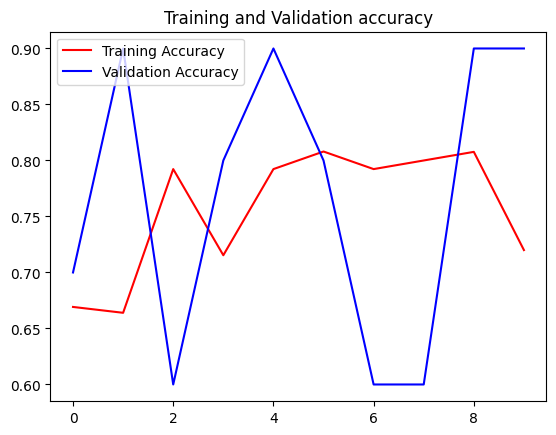

In [137]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.title('Training and Validation accuracy')
plt.legend(loc = 'best')
plt.show()

Membuat arsitektur deep learning lagi dengan convolutional 2 layer, dengan jumlah filter yang pertama 16 dan layer ke dua 32 filter, sisanya masih sama seperti arsitektur di atas.

In [141]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu', input_shape = (150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(200, activation = 'relu'),
        tf.keras.layers.Dropout(0.3,seed=112),
        tf.keras.layers.Dense(500, activation = 'relu'),
        tf.keras.layers.Dropout(0.5,seed=112),
        tf.keras.layers.Dense(2, activation = 'sigmoid'),
])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 74, 74, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 36, 36, 32)        0         
 ng2D)                                                           
                                                                 
 flatten_7 (Flatten)         (None, 41472)             0         
                                                                 
 dense_21 (Dense)            (None, 200)              

In [142]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'Adam',
              metrics = ['accuracy'])

Proses training dengan epoch 10 dan step setiap epoch 13

In [143]:
history = model.fit(
            train_generator,
            steps_per_epoch = 13,
            epochs = 10,
            validation_data = val_generator,
            validation_steps = 1,
            verbose = 1,
            callbacks= [callbacks]
)

Epoch 1/10
13/13 [==============================] - 8s 494ms/step - loss: 0.9611 - accuracy: 0.5385 - val_loss: 0.3529 - val_accuracy: 0.9000
Epoch 2/10
13/13 [==============================] - 6s 456ms/step - loss: 0.6970 - accuracy: 0.5462 - val_loss: 0.6618 - val_accuracy: 0.6000
Epoch 3/10
13/13 [==============================] - 7s 545ms/step - loss: 0.6020 - accuracy: 0.7462 - val_loss: 0.8818 - val_accuracy: 0.6000
Epoch 4/10
13/13 [==============================] - 7s 548ms/step - loss: 0.5871 - accuracy: 0.7000 - val_loss: 0.5514 - val_accuracy: 0.6000
Epoch 5/10
13/13 [==============================] - 7s 559ms/step - loss: 0.6517 - accuracy: 0.6154 - val_loss: 0.6090 - val_accuracy: 0.8000
Epoch 6/10
13/13 [==============================] - 7s 536ms/step - loss: 0.6166 - accuracy: 0.7200 - val_loss: 0.3908 - val_accuracy: 0.9000
Epoch 7/10
13/13 [==============================] - 7s 573ms/step - loss: 0.6212 - accuracy: 0.6692 - val_loss: 0.5274 - val_accuracy: 0.7000
Epoch 

seperti kita lihat yang sekarang terlihat lebih baik dimana akurasi berada di sekitar 0.7 val akurasi 0.8 dan val loss nya 0.3

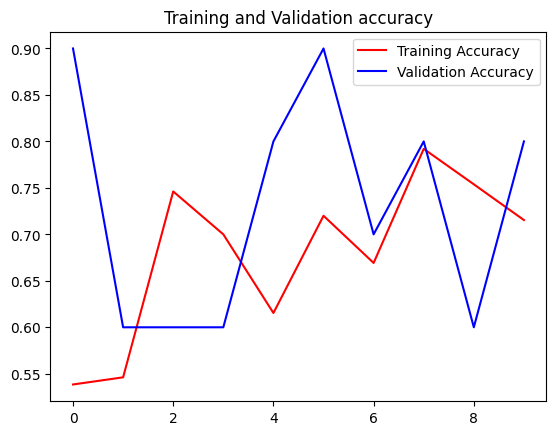

In [150]:

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.title('Training and Validation accuracy')
plt.legend(loc = 'best')
plt.show()

Melakukan test dengan gambar dari internet dan menunjukan hasil nya tepat namun *percent confidence*  nya hanya 73.11%

1/1 [==============================] - 0s 30ms/step
tf.Tensor([0.7310586  0.26894143], shape=(2,), dtype=float32)
This image most likely belongs to bagus with a 73.11 percent confidence.


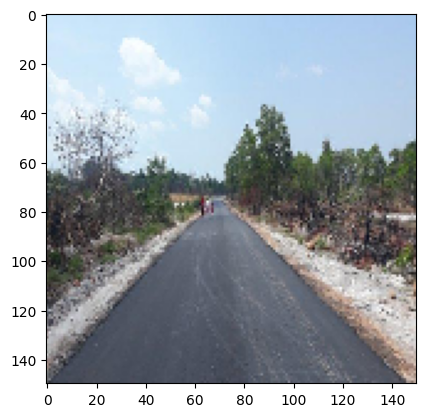

In [149]:
image_baru_url = "https://asset-2.tstatic.net/bangka/foto/bank/images/jalan-aspal-sepanjang-32-km-di-dusun-sungai-tebok-kecamatan-lubuk-besar.jpg"
image_baru_path = tf.keras.utils.get_file('jalan besar', origin=image_baru_url)
img = tf.keras.utils.load_img(
   image_baru_path, target_size=(150, 150)
)
plt.imshow(img)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch


predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])


print(score)
if np.argmax(score) == 0:
  print("This image most likely belongs to bagus with a {:.2f} percent confidence." .format(100 * np.max(score)))
else:
  print("This image most likely belongs to jelek with a {:.2f} percent confidence." .format(100 * np.max(score)))